In [1]:
from models.vae_allhist_glm import VAE_AllHist_GLM, NN_Encoder

import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

V[V<0.3] = 0

In [3]:
T_train = 80 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 401
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 5000
epoch_no = 15
layer_no = 3

In [4]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = VAE_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.002)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

33824
95


In [6]:
P_prior = torch.ones(batch_size, sub_no-1).to(device) * 0.001
temp_list = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
temp_count = 0

t = torch.arange(100).to(device)
t_tau = t / 6
kern = t_tau * torch.exp(-t_tau) * 1.75
kern = torch.flip(kern, [0])

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    #if (i%500==0) & (temp_count < 14):
        #temp = temp_list[temp_count]
        #temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_enc, P_enc = encoder(batch_V, batch_E_neural, batch_I_neural)
    
    Z_enc_in = torch.zeros(batch_size, sub_no).to(device)
    Z_enc_in[:,0] = Z_enc_in[:,0] + batch_Z
    Z_enc_in[:,1:] = Z_enc_in[:,1:] + Z_enc
    
    P_dec, out_filters = decoder.train_forward(batch_E_neural, batch_I_neural, Z_enc_in)

    prior_loss = bce_criterion(P_enc , P_prior)
    hid_bern_loss = bce_criterion(P_dec[:,1:], P_enc.detach())
    vis_bern_loss = bce_criterion(P_dec[:,0], batch_Z)
        
    loss = prior_loss + hid_bern_loss + vis_bern_loss
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    if i%250 == 249:
        test_Z_dec, test_P_dec, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
         
        test_bern_loss = bce_criterion(test_P_dec[:,0], Z_test)
        
        Z_pad = torch.zeros(99+T_test).to(device)
        Z_pad[-T_test:] = test_Z_dec[:,0]
        V_conv = F.conv1d(Z_pad.reshape(1,1,-1), kern.reshape(1,1,-1)).flatten()
        test_var = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=V_conv.cpu().detach().numpy())
        
        print(i, "VAR:", np.round(test_var , 6),
              "TEST BERN:", np.round(test_bern_loss.item(), 6),
              "TRAIN TOT:", np.round(torch.sum(Z_enc).item(), 6),
              "TRAIN HID:", np.round(hid_bern_loss.item(), 6), 
              "TRAIN PRIOR:", np.round(prior_loss.item(), 6))


<ipython-input-6-1eb45a6ef488>:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


249 VAR: -22.117319 TEST BERN: 0.151361 TRAIN TOT: 58.174774 TRAIN HID: 0.492832 TRAIN PRIOR: 0.013198
499 VAR: -7.123639 TEST BERN: 0.056683 TRAIN TOT: 53.289875 TRAIN HID: 0.346539 TRAIN PRIOR: 0.013198
749 VAR: -4.405754 TEST BERN: 0.034793 TRAIN TOT: 42.858047 TRAIN HID: 0.252296 TRAIN PRIOR: 0.013386
999 VAR: -3.340138 TEST BERN: 0.026444 TRAIN TOT: 70.488426 TRAIN HID: 0.189385 TRAIN PRIOR: 0.012297
1249 VAR: -2.8238 TEST BERN: 0.021874 TRAIN TOT: 71.61731 TRAIN HID: 0.145872 TRAIN PRIOR: 0.012068
1499 VAR: -2.325383 TEST BERN: 0.019662 TRAIN TOT: 86.657974 TRAIN HID: 0.114863 TRAIN PRIOR: 0.01059
1749 VAR: -2.117583 TEST BERN: 0.016759 TRAIN TOT: 313.772217 TRAIN HID: 0.091461 TRAIN PRIOR: 0.008386
1999 VAR: -1.849606 TEST BERN: 0.015655 TRAIN TOT: 693.980469 TRAIN HID: 0.073758 TRAIN PRIOR: 0.00891
2249 VAR: -1.640048 TEST BERN: 0.014517 TRAIN TOT: 682.914856 TRAIN HID: 0.062406 TRAIN PRIOR: 0.008873
2499 VAR: -1.663691 TEST BERN: 0.013994 TRAIN TOT: 770.019958 TRAIN HID: 0.054

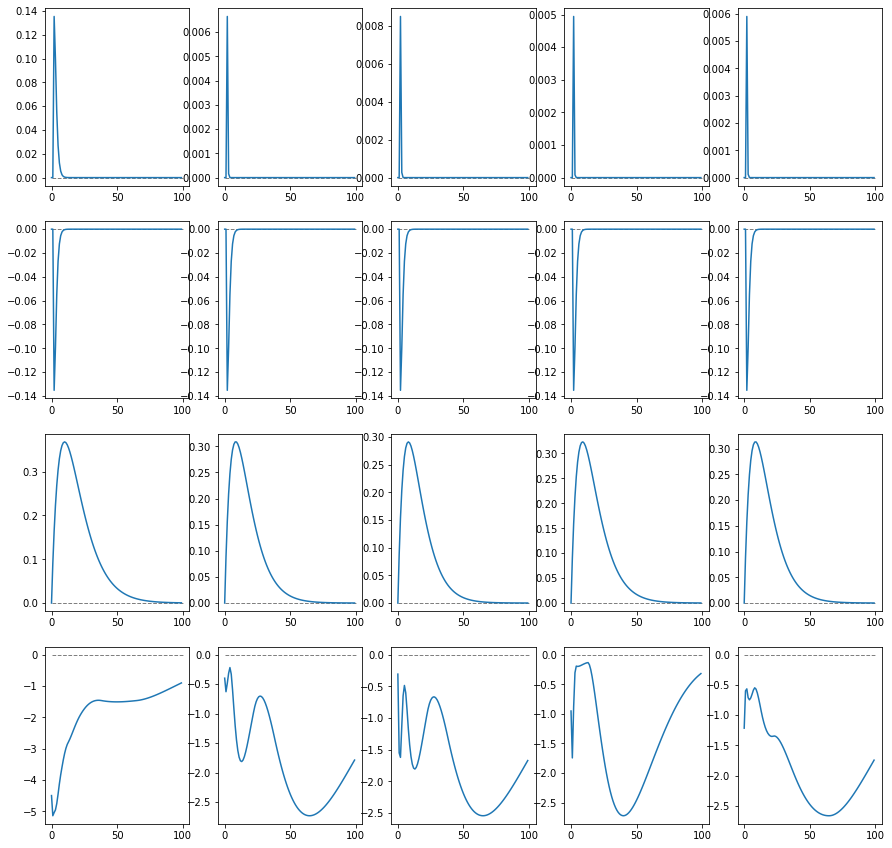

In [7]:
sub_no = 5
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:100])
        axs[row,col].hlines(y=0,xmin=0,xmax=100, color="gray",linewidth=1,linestyle="--")

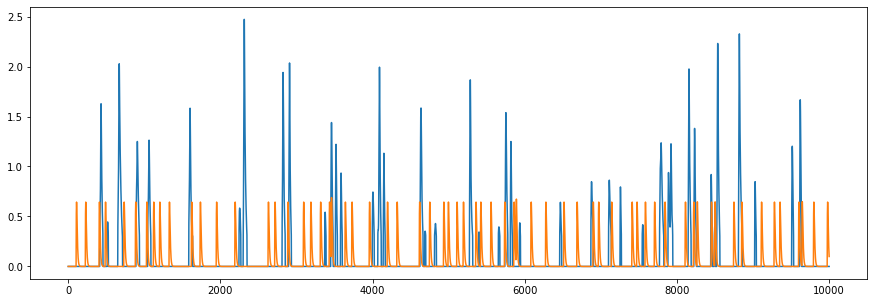

In [8]:
plt.figure(figsize=(15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(V_conv.cpu().detach().numpy()[16000:26000])

In [9]:
print(decoder.Tau_spk)

Parameter containing:
tensor([2.3000, 2.1349, 2.0817, 2.1766, 2.1493], device='cuda:0',
       requires_grad=True)


In [10]:
print(decoder.W_syn)

Parameter containing:
tensor([[-1.0000, -1.0000],
        [-2.0671, -1.0000],
        [-2.0402, -1.0000],
        [-2.1009, -1.0000],
        [-2.0854, -1.0000]], device='cuda:0', requires_grad=True)


In [11]:
print(decoder.Tau_syn)

Parameter containing:
tensor([[ 0.0000,  0.0000],
        [-1.4901,  0.0000],
        [-1.4231,  0.0000],
        [-1.5628,  0.0000],
        [-1.5187,  0.0000]], device='cuda:0', requires_grad=True)


In [12]:
print(decoder.W_hist)

Parameter containing:
tensor([[-1.8135,  1.5546, -1.5852, -1.6170, -1.3605,  1.1377, -1.0795, -0.4482,
         -1.1688],
        [-0.4508, -0.6268, -0.5239,  0.2816,  0.1549, -1.3306, -0.2474, -0.1786,
         -1.6476],
        [ 0.1867,  0.7392,  1.1766,  0.1648, -0.1063,  1.3309,  0.2467,  0.0704,
          1.5944],
        [-0.2289,  1.3414,  0.2253, -0.3464, -0.3060, -0.2596, -0.2009, -1.5789,
         -0.6241],
        [-1.0760,  0.3368,  0.4674, -0.7201, -0.4884,  0.4014, -1.1190, -0.1670,
          1.6267]], device='cuda:0', requires_grad=True)
